In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

from sklearn.metrics import f1_score



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

df = pd.read_csv("train.csv", usecols=["cleanedreddit", "label"])
train_inputs = df["cleanedreddit"].to_list()
train_labels = df["label"].to_list()

df = pd.read_csv("val.csv", usecols=["cleanedreddit", "label"])
val_inputs = df["cleanedreddit"].to_list()
val_labels = df["label"].to_list()

num_classes = 3



unk_ind = 1
class VocabEncoder():
    def __init__(self, vocab):
        self.encoder = {word : index for index, word in enumerate(vocab)}
    
    def __call__(self, tokens):
        return [self.encoder[token] if self.encoder.get(token) else unk_ind for token in tokens]

class CustomDataset(Dataset):
    def __init__(self, inputs, labels, vocab_encoder, max_length):
        self.inputs = [vocab_encoder(x.split(" ")) for x in inputs]
        self.inputs = [torch.tensor(x[:max_length]) for x in self.inputs]
        self.labels = labels

    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, index):
        return self.inputs[index], self.labels[index]

class RNNClassifier(nn.Module):
    def __init__(self, output_size, hidden_size, num_layers, embedding_weights):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Embedding.from_pretrained(torch.from_numpy(embedding_weights).float(), freeze=True),
            nn.GRU(
                input_size = 300,
                hidden_size = hidden_size,
                batch_first = True,
                bidirectional = False,
                num_layers = num_layers,
                dropout = 0.2
            )
        )
        self.flatten = nn.Flatten()
        self.classifier = nn.Linear(hidden_size*num_layers, output_size)

    def forward(self, x):
        _, hfinal = self.encoder(x)
        y = torch.transpose(hfinal, 0, 1)
        y = self.flatten(y)
        y = self.classifier(y)
        return y

    
pad_ind = 0
def collate_fn(batch):
    inputs, labels = zip(*batch)
    inputs = pad_sequence(inputs, batch_first=True, padding_value=pad_ind)
    return inputs, torch.tensor(labels)


vocab = np.load("vocab_npa.npy", allow_pickle=True)        
vocab_encoder = VocabEncoder(vocab)
embedding_weights = np.load("embs_npa.npy", allow_pickle=True)

train_dataset = CustomDataset(train_inputs, train_labels, vocab_encoder, max_length = 100)
train_dataloader = DataLoader(train_dataset, batch_size = 64, shuffle=True, collate_fn = collate_fn)

val_dataset = CustomDataset(val_inputs, val_labels, vocab_encoder, max_length = 100)
val_dataloader = DataLoader(val_dataset, batch_size = 64, shuffle=False, collate_fn = collate_fn)

model = RNNClassifier(num_classes, hidden_size = 256, num_layers = 3, embedding_weights = embedding_weights)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for i in range(num_epochs):
    print(f"Epoch {i+1}")
    train_loss = 0
    val_loss = 0

    model.train()
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        predictions = model(inputs)
        loss = criterion(predictions, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f"train loss: {train_loss}")

    model.eval()
    val_predictions = []
    val_targets = []
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            predictions = model(inputs)
            loss = criterion(predictions, labels)
            val_loss += loss.item()
            val_targets += labels.cpu()
            val_predictions += predictions.cpu().argmax(dim=1)

    print(f"val loss: {val_loss}")
    print(f1_score(val_predictions, val_targets, average=None))


torch.save(model.state_dict(), "chkpt.pt")


Epoch 1
train loss: 264.59188947826624
val loss: 42.02214998006821
[0.86816174 0.86039402 0.94385119]
Epoch 2
train loss: 164.41096784174442
val loss: 41.26864381879568
[0.87199856 0.86815416 0.9355102 ]
Epoch 3
train loss: 146.19035998359323
val loss: 41.206388138234615
[0.87626093 0.86037234 0.93411681]
Epoch 4
train loss: 136.99530904367566
val loss: 35.677102729678154
[0.8839993  0.88275862 0.95398052]
Epoch 5
train loss: 128.18093361705542
val loss: 37.8855524584651
[0.87740425 0.86705406 0.95069233]
Epoch 6
train loss: 120.00097509473562
val loss: 39.08534103631973
[0.87804878 0.86773968 0.94617564]
Epoch 7
train loss: 115.46188193932176
val loss: 37.611668922007084
[0.87338129 0.87808869 0.95515316]
Epoch 8
train loss: 100.41473469510674
val loss: 41.14269768446684
[0.87417905 0.87300223 0.95196653]
Epoch 9
train loss: 89.50292988494039
val loss: 43.377297922968864
[0.84891548 0.85870243 0.94879725]
Epoch 10
train loss: 77.81939489208162
val loss: 46.88392383605242
[0.872497   0

In [2]:
df = pd.read_csv("test.csv", usecols=["cleanedreddit", "label"])
test_inputs = df["cleanedreddit"].to_list()
test_labels = df["label"].to_list()

test_dataset = CustomDataset(test_inputs, test_labels, vocab_encoder, max_length = 100)
test_dataloader = DataLoader(test_dataset, batch_size = 256, shuffle=False, collate_fn = collate_fn)

model.eval()
test_predictions = []
test_targets = []
test_loss = 0
with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        predictions = model(inputs)
        loss = criterion(predictions, labels)
        test_loss += loss.item()
        test_targets += labels.cpu()
        test_predictions += predictions.cpu().argmax(dim=1)

print(f"test loss: {test_loss}")
print(f1_score(test_predictions, test_targets, average=None))

test loss: 3.132678598165512
[0.87837838 0.8952381  0.76190476]


In [3]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [4]:
print(classification_report(test_targets, test_predictions, digits=4))

              precision    recall  f1-score   support

           0     0.7992    0.9750    0.8784       200
           1     0.8545    0.9400    0.8952       200
           2     0.9412    0.6400    0.7619       200

    accuracy                         0.8517       600
   macro avg     0.8650    0.8517    0.8452       600
weighted avg     0.8650    0.8517    0.8452       600



Text(33.0, 0.5, 'True Label')

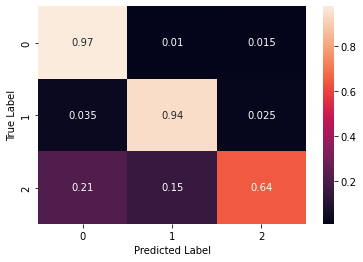

In [5]:
s = sns.heatmap(confusion_matrix(test_targets, test_predictions, normalize="true"), annot=True)
s.set_xlabel('Predicted Label', fontsize=10)
s.set_ylabel('True Label', fontsize=10)

In [6]:
df = pd.read_csv("twitter_test.csv", usecols=["cleanedtweet", "label"])
test_inputs = df["cleanedtweet"].to_list()
test_labels = df["label"].to_list()

test_dataset = CustomDataset(test_inputs, test_labels, vocab_encoder, max_length = 100)
test_dataloader = DataLoader(test_dataset, batch_size = 256, shuffle=False, collate_fn = collate_fn)

model.eval()
test_predictions = []
test_targets = []
test_loss = 0
with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        predictions = model(inputs)
        loss = criterion(predictions, labels)
        test_loss += loss.item()
        test_targets += labels.cpu()
        test_predictions += predictions.cpu().argmax(dim=1)

print(f"test loss: {(test_loss/len(test_dataset))*10000}")
print(f1_score(test_predictions, test_targets, average=None))

test loss: 9.556843340396881
[0.92574257 0.97029703 0.92857143]


In [7]:
print(classification_report(test_targets, test_predictions, digits=4))

              precision    recall  f1-score   support

           0     0.9167    0.9350    0.9257       200
           1     0.9608    0.9800    0.9703       200
           2     0.9479    0.9100    0.9286       200

    accuracy                         0.9417       600
   macro avg     0.9418    0.9417    0.9415       600
weighted avg     0.9418    0.9417    0.9415       600



Text(33.0, 0.5, 'True Label')

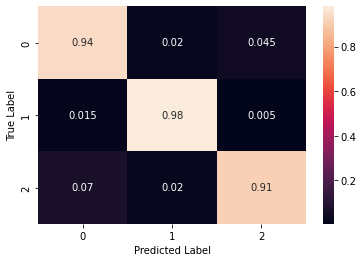

In [8]:
s = sns.heatmap(confusion_matrix(test_targets, test_predictions, normalize="true"), annot=True)
s.set_xlabel('Predicted Label', fontsize=10)
s.set_ylabel('True Label', fontsize=10)

In [9]:
df = pd.read_csv("train.csv", usecols=["cleanedreddit", "label"])
df.loc[df["label"] == 0, "label"] = "Anxiety"
df.loc[df["label"] == 1, "label"] = "Depression"
df.loc[df["label"] == 2, "label"] = "Neutral"

In [10]:
df["label"].value_counts()

Neutral       11720
Depression    11720
Anxiety       11720
Name: label, dtype: int64

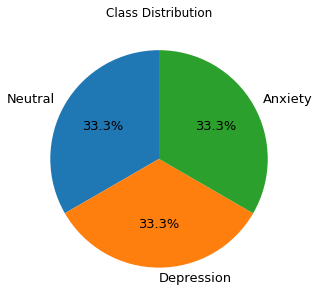

In [11]:
import matplotlib.pyplot as plt
kwargs = dict(
    startangle = 90,
    fontsize   = 13,
    figsize    = (60,5),
    autopct    = '%1.1f%%',
    label      = ''
)

ax = df['label'].value_counts().plot(kind="pie", **kwargs, title = "Class Distribution")